In [2]:
import pyrootutils
root = pyrootutils.setup_root(".", pythonpath=True, cwd=True)

In [24]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from src.train import FaceAgeModule
from src.data.face_age_datamodule import FaceAgeDataModule

In [4]:
age_norm_value = 80

In [5]:
model = FaceAgeModule.load_from_checkpoint("logs/checkpoints/best-checkpoint.ckpt").eval()
dm = FaceAgeDataModule(use_augmented=False, normalize_age_by=age_norm_value, num_workers=8, batch_size=32)
dm.setup()

Loaded pretrained weights for efficientnet-b0


In [6]:
all_preds = []
all_targets = []
for x, y in tqdm(dm.test_dataloader()):

    preds = model.predict(x)
    preds = preds.detach()
    
    preds = preds.cpu().numpy() * age_norm_value
    targets = y.cpu().numpy() * age_norm_value
    
    preds = preds.clip(1, age_norm_value)
    
    all_preds.append(preds)
    all_targets.append(targets)

all_preds = np.concatenate(all_preds).astype(int)
all_targets = np.concatenate(all_targets).astype(int)

100%|██████████| 49/49 [00:53<00:00,  1.09s/it]


In [30]:
all_targets.shape, all_preds.shape
# print(all_preds.min(), all_preds.max())
# print(all_targets.min(), all_targets.max())

((1556, 1), (1556, 1))

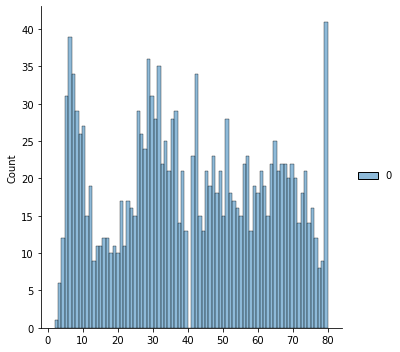

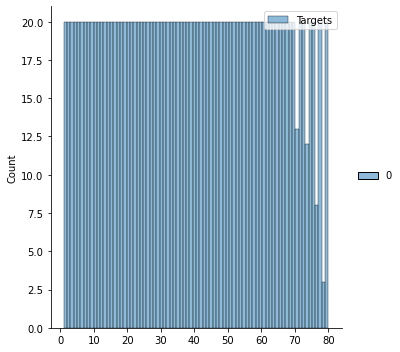

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(all_preds,label="Predictions", bins=age_norm_value)
sns.displot(all_targets, label="Targets", bins=age_norm_value)
plt.legend()
plt.show()

In [31]:
# calculate MAE
from sklearn.metrics import mean_absolute_error

mean_absolute_error(all_targets, all_preds)

6.895886889460154

/home/ukasz/miniconda3/envs/myenv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ukasz/miniconda3/envs/myenv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


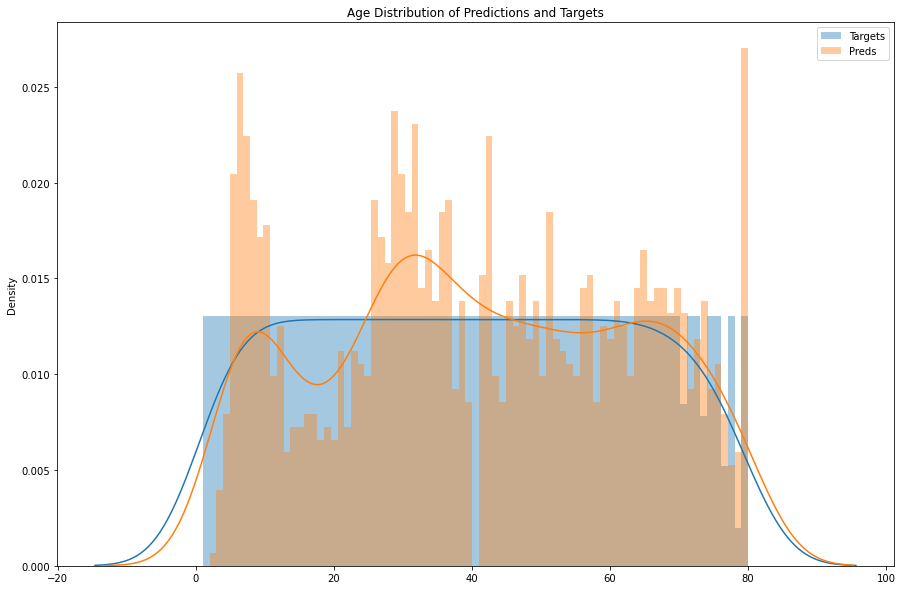

In [41]:
# set figure size
plt.figure(figsize=(15,10))

sns.distplot(all_targets, kde=True, bins=age_norm_value, label="Targets")
sns.distplot(all_preds, kde=True, bins=age_norm_value, label="Preds")

plt.title("Age Distribution of Predictions and Targets")

plt.legend()

In [46]:
# preds and targets are list of integers from range 1 to 80
# binarize them into `1-5``, `5-10`, `10-15`, ..., `75-80`

preds_binned = np.digitize(all_preds, np.arange(0, 85, 5))
targets_binned = np.digitize(all_targets, np.arange(0, 85, 5))

# calculate accuracy
acc = (preds_binned == targets_binned).mean()

print(acc)

0.2622107969151671


In [47]:
preds_binned = np.digitize(all_preds, np.arange(0, 85, 10))
targets_binned = np.digitize(all_targets, np.arange(0, 85, 10))

# calculate accuracy
acc = (preds_binned == targets_binned).mean()

print(acc)

0.4691516709511568


In [48]:
preds_binned = np.digitize(all_preds, np.arange(0, 85, 15))
targets_binned = np.digitize(all_targets, np.arange(0, 85, 15))

# calculate accuracy
acc = (preds_binned == targets_binned).mean()

print(acc)

0.596401028277635


/home/ukasz/miniconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


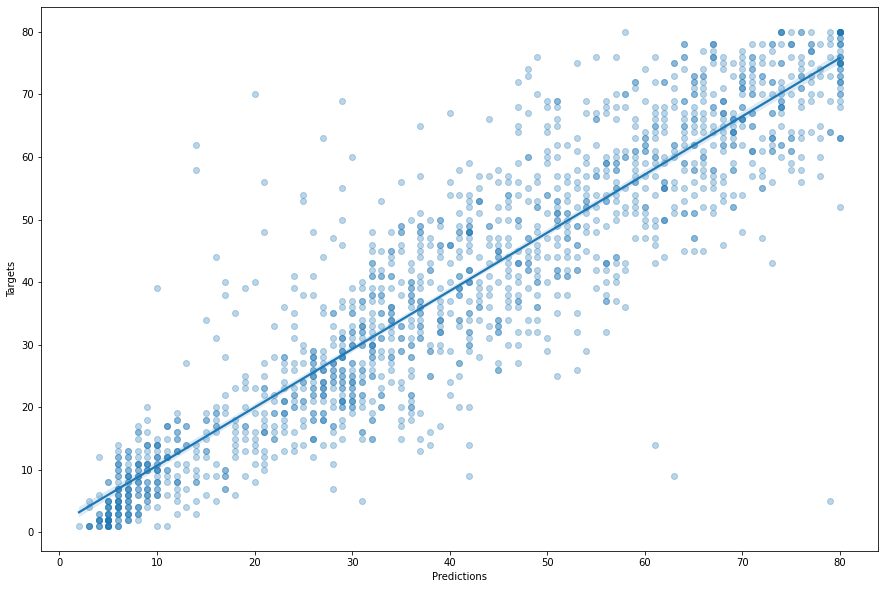

In [50]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.regplot(all_preds, all_targets, scatter_kws={"alpha": 0.3})
plt.xlabel("Predictions")
plt.ylabel("Targets")
plt.show()